## Neural network for sector classification
The neural network maps the company sectors to the descriptions.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [66]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    """Convert the Pandas' dataset into a tensorflow dataset and shuffle and batch the entries."""
    df = dataframe.copy()
    code = df.pop('code')
    df = dataframe["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

### Dataset with normal sentences

In [67]:
df = pd.read_json('..\\06_data_prep.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,description,sector,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,3


In [68]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [69]:
# convert data to tensorflow datasets
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [70]:
# import a token based text embedding on English Google News with pre-built out-of-vocabulary handling
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [71]:
# built a neural network for classification with kernel regularization to decrease overfitting
model = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# set early stopping
es = EarlyStopping(patience=1, verbose=1, restore_best_weights=True)

In [73]:
# train the model and use early stopping
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    callbacks=[es])

Epoch 1/20
123/123 [==============================] - 91s 736ms/step - loss: 2.0161 - accuracy: 0.5400 - val_loss: 1.6348 - val_accuracy: 0.6599
Epoch 2/20
123/123 [==============================] - 90s 736ms/step - loss: 1.1261 - accuracy: 0.7827 - val_loss: 1.2745 - val_accuracy: 0.7146
Epoch 3/20
123/123 [==============================] - 89s 728ms/step - loss: 0.8100 - accuracy: 0.8746 - val_loss: 1.1226 - val_accuracy: 0.7409
Epoch 4/20
123/123 [==============================] - 89s 725ms/step - loss: 0.6405 - accuracy: 0.9246 - val_loss: 1.0430 - val_accuracy: 0.7540
Epoch 5/20
123/123 [==============================] - 83s 675ms/step - loss: 0.5281 - accuracy: 0.9555 - val_loss: 0.9918 - val_accuracy: 0.7540
Epoch 6/20
123/123 [==============================] - 51s 415ms/step - loss: 0.4515 - accuracy: 0.9738 - val_loss: 1.0196 - val_accuracy: 0.7419
Epoch 00006: early stopping


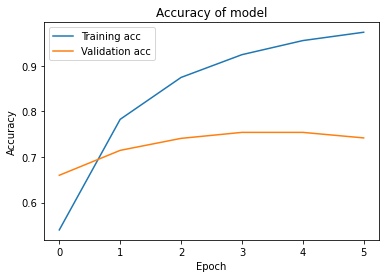

In [74]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

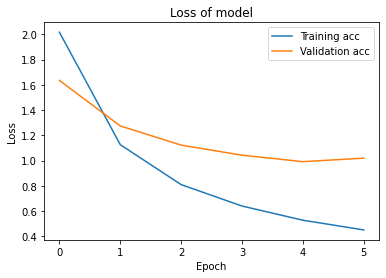

In [75]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [76]:
model.evaluate(test_data)

16/16 [==============================] - 1s 53ms/step - loss: 0.9529 - accuracy: 0.7688


[0.9529468417167664, 0.7688391208648682]

## Dataset without stopwords and lemmatization

In [77]:
df = pd.read_json('..\\06_data_prep.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,description,sector,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,3


In [78]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [79]:
column = 'explicit_lemmatization'

train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [80]:
# import a token based text embedding on English Google News with pre-built out-of-vocabulary handling
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [81]:
# built a neural network for classification with kernel regularization to decrease overfitting
model = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

In [82]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# set early stopping
es = EarlyStopping(patience=1, verbose=1, restore_best_weights=True)

In [83]:
# train the model and use early stopping
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    callbacks=[es])

Epoch 1/20
123/123 [==============================] - 51s 416ms/step - loss: 2.1295 - accuracy: 0.4489 - val_loss: 1.7328 - val_accuracy: 0.5901
Epoch 2/20
123/123 [==============================] - 51s 415ms/step - loss: 1.1868 - accuracy: 0.7479 - val_loss: 1.3033 - val_accuracy: 0.7115
Epoch 3/20
123/123 [==============================] - 51s 414ms/step - loss: 0.8157 - accuracy: 0.8672 - val_loss: 1.2231 - val_accuracy: 0.7045
Epoch 4/20
123/123 [==============================] - 51s 415ms/step - loss: 0.6279 - accuracy: 0.9199 - val_loss: 1.1036 - val_accuracy: 0.7530
Epoch 5/20
123/123 [==============================] - 51s 416ms/step - loss: 0.5112 - accuracy: 0.9541 - val_loss: 1.0537 - val_accuracy: 0.7520
Epoch 6/20
123/123 [==============================] - 51s 416ms/step - loss: 0.4331 - accuracy: 0.9751 - val_loss: 1.0422 - val_accuracy: 0.7530
Epoch 7/20
123/123 [==============================] - 51s 415ms/step - loss: 0.3776 - accuracy: 0.9882 - val_loss: 1.0016 - val_ac

In [84]:
model.evaluate(test_data)

16/16 [==============================] - 1s 58ms/step - loss: 0.8744 - accuracy: 0.8065


[0.874370813369751, 0.8065173029899597]